## Using expenditure surveys to construct household-level prices indices to assess how experiences of inflation vary across the income distribution

**Key parts**
1. Preprocessing: Cut certain columns, combine others and impute missing data
2. Preliminaty models and visualizations: Graph relevant variable distributions and get some insights on general trends
3. Fixed-effects model: Fit a linear regression with and without relevant controls
4. Multilevel model: Fit a multilevle model with random slopes and random intercepts for 12 to model the trend at a sub-national level
5. Testing underlying assumptions: Conduct test for linearity, multicolinearity, homoscedasitcity, independence of residuals, normally distributed residuals.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Imputation
from fancyimpute import IterativeImputer

# Statistical modeling
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.api import OLS, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression

# Additional statistical tools
import scipy.stats as stats

----

**Part 1: Data processing - deriving household-level indices**

----

In [2]:
# Import data

file_path = "/Users/gianjaeger/Desktop/Stats/UKDA-9123-tab copy/tab/lcfs_2021_dvhh_urbanrural_ukanon.tab"  # Adjust path if needed
data2022 = pd.read_csv(file_path, sep='\t')

/var/folders/n5/_f2xjmkj39gb7s0th_6lyk9w0000gn/T/ipykernel_54466/198568020.py:4: DtypeWarning: Columns (1870,1873) have mixed types. Specify dtype option on import or set low_memory=False.
  data2022 = pd.read_csv(file_path, sep='\t')


In [3]:
# List of columns to keep for all dataframes
columns_to_keep = [
    'A060', 'A091', 'A093', 'B010', 'B387hp', 'EqIncDMp', 'EqIncDOp',
    'P600t', 'P601t', 'P602t', 'P603t', 'P604t', 'P605t', 'P606t',
    'P607t', 'P608t', 'P609t', 'P610t', 'P611t', 'P612t', "SexHRP", 
    "B228", "P204", "Gorx", "a065p", "URGridEWp", "P365p", "A121", 
    "URGridSCp", "p396p", "A049"
]

# Filter
filtered_data2022 = data2022[columns_to_keep]

In [4]:
# Category specific rates for 2022 from the ONS
inflation_rates_2022 = {
    'P601t': 14.545455,
    'P602t': 9.0836653,
    'P603t': 6.7889908,
    'P604t': 9.664848,
    'P605t': 5.8479532,
    'P606t': 7.6660988,
    'P607t': 0.2235469,
    'P608t': 7.0826307,
    'P609t': 5.7724958,
    'P610t': 3.5573123,
    'P611t': 9.3799682,
    'P612t': 5.8234759
}

# Ensure you're working on a copy of the DataFrame to avoid warnings
filtered_data2022 = filtered_data2022.copy()

# Calculate the total spending per individual
filtered_data2022.loc[:, 'total_spending'] = filtered_data2022[list(inflation_rates_2022.keys())].sum(axis=1)

# Calculate the spending share for each category
for category in inflation_rates_2022.keys():
    filtered_data2022.loc[:, f'{category}_share'] = filtered_data2022[category] / filtered_data2022['total_spending']

# Calculate the experienced inflation for each individual
filtered_data2022.loc[:, 'experienced_inflation'] = sum(
    filtered_data2022[f'{category}_share'] * inflation_rates_2022[category]
    for category in inflation_rates_2022.keys()
)

# Calculate the average of the 'experienced_inflation' column
average_inflation = filtered_data2022['experienced_inflation'].mean()

print(f"The average experienced inflation is: {average_inflation}")

The average experienced inflation is: 7.731462671286976


In [5]:
# Rename the columns in the filtered DataFrame
filtered_data2022 = filtered_data2022.rename(columns={
    'A060': 'Gross_normal_income',
    'A091': 'Socioeconomic_group',
    'B010': 'Rent_rates',
    'B387hp': 'Tax_paid',
    'EqIncDMp': 'Equivalised_income_McClements',
    'EqIncDOp': 'Equivalised_income_OECD_Scale',
    'P600t': 'Total_consumption_expenditure',
    'P601t': 'Food',
    'P602t': 'Alcoholic_and_tobacco',
    'P603t': 'Clothing',
    'P604t': 'Housing',
    'P605t': 'Furnishings',
    'P606t': 'Health',
    'P607t': 'Transport',
    'P608t': 'Communication',
    'P609t': 'Recreation',
    'P610t': 'Education',
    'P611t': 'Restaurants',
    'P612t': 'Miscellaneous',
    'B228': 'Personal_pension',
    'P204': 'Housing_benefit',
    'Gorx': 'Location',
    'a065p': 'Age_rank',
    'URGridEWp': 'Urban',
    'P365p': 'Pension',
    'A121': 'Own_vs_rent',
    'URGridSCp': 'Rural2',
    'p396p': 'Age',
    'A093': 'Job',
    'A049': "Household_size"
})

In [6]:
# Remove individuals with negative Equivalised_income_McClements values
filtered_data2022 = filtered_data2022[filtered_data2022['Equivalised_income_McClements'] >= 0]

In [7]:
# "Cleaning" up control variables (e.g., binary encoding, combining, and imputing)

# 1. Tenure: Ensure that all versions of owning and renting are merged into one binary column (Own_vs_rent_binary)
filtered_data2022['Own_vs_rent_binary'] = filtered_data2022['Own_vs_rent'].apply(
    lambda x: 0 if x in [1, 2, 3, 4, 8] else (1 if x in [5, 6, 7] else None)
)

# 2. Household size: Turn all households with 5 or more members into category 5
filtered_data2022['Household_size'] = filtered_data2022['Household_size'].apply(lambda x: 5 if x > 5 else x)

# 3. Job: Modify the `filtered_data2022` DataFrame to create the new column `Job_control`
filtered_data2022['Job_control'] = filtered_data2022['Job'].replace({5: None, 7: 5, 6: 5})

# 4. Retirement status: Using my Job_control colum create a Retired_vs_other column (all 5s should be 0s and all other numbers should be 1s) 
filtered_data2022['Retired_vs_other'] = filtered_data2022['Job_control'].apply(lambda x: 0 if x == 5 else 1)

# 5a. Rural living status 
filtered_data2022['Rural_or_urban'] = (filtered_data2022['Urban'].astype(str) + filtered_data2022['Rural2'].astype(str)).astype(object)
filtered_data2022['Rural_or_urban'] = filtered_data2022['Rural_or_urban'].str.strip()

/var/folders/n5/_f2xjmkj39gb7s0th_6lyk9w0000gn/T/ipykernel_54466/3493986064.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_data2022['Job_control'] = filtered_data2022['Job'].replace({5: None, 7: 5, 6: 5})


In [8]:
# 5b. Impute missing urban/rural values via iterative random forrest imputation

# Replace empty values with NaN
filtered_data2022['Rural_or_urban'] = filtered_data2022['Rural_or_urban'].replace('', np.nan)

# Impute
imputer = IterativeImputer()
filtered_data2022[['Rural_or_urban']] = imputer.fit_transform(filtered_data2022[['Rural_or_urban']])

# Round all to the nearest integer
filtered_data2022['Rural_or_urban'] = filtered_data2022['Rural_or_urban'].round()

---

**Part 2: Preliminary modelling and graphing**

---

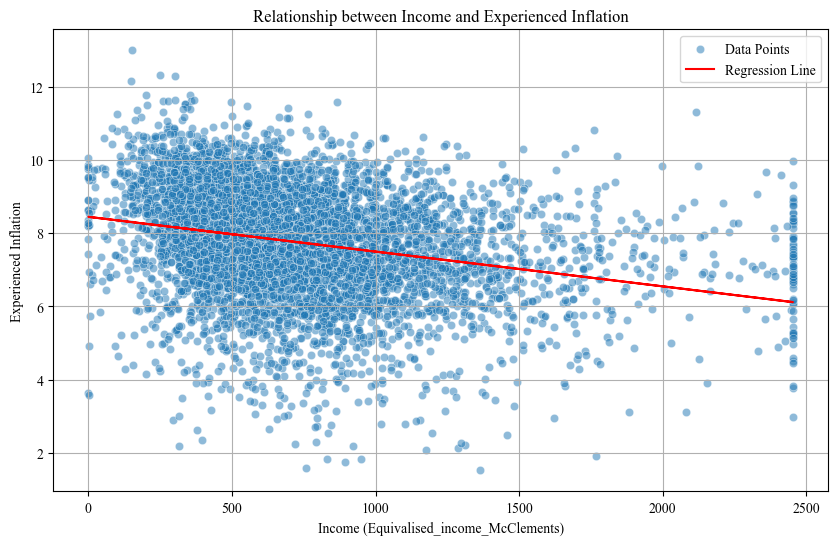

(np.float64(-0.0009488652510540801), np.float64(8.441517952994403))

In [9]:
# Extracting the variables for regression
X = filtered_data2022['Equivalised_income_McClements'].values.reshape(-1, 1)  # Income as X
y = filtered_data2022['experienced_inflation'].values  # Inflation as y

# Linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Set font to Times New Roman
plt.rc('font', family='Times New Roman')

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Equivalised_income_McClements', y='experienced_inflation', data=filtered_data2022, alpha=0.5, label="Data Points")
plt.plot(filtered_data2022['Equivalised_income_McClements'], y_pred, color='red', label="Regression Line")
plt.title('Relationship between Income and Experienced Inflation')
plt.xlabel('Income (Equivalised_income_McClements)')
plt.ylabel('Experienced Inflation')
plt.legend()
plt.grid(True)
plt.show()

# Output regression coefficients
slope = model.coef_[0]
intercept = model.intercept_

(slope, intercept)

In [10]:
# Add a new column for income decile 
filtered_data2022['income_decile'] = pd.qcut(filtered_data2022['Equivalised_income_McClements'], q=10, labels=range(1, 11))

/var/folders/n5/_f2xjmkj39gb7s0th_6lyk9w0000gn/T/ipykernel_54466/1842020509.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


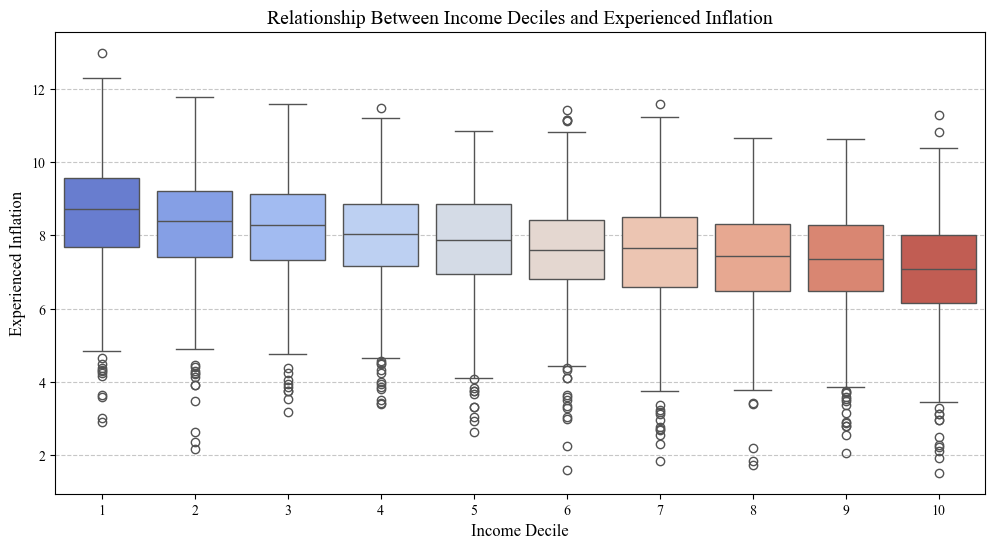

In [11]:
# Set font to Times New Roman
plt.rc('font', family='Times New Roman')

# Create a boxplot to explore the relationship between income deciles and experienced inflation
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='income_decile',
    y='experienced_inflation',
    data=filtered_data2022,
    palette="coolwarm"
)
plt.title('Relationship Between Income Deciles and Experienced Inflation', fontsize=14)
plt.xlabel('Income Decile', fontsize=12)
plt.ylabel('Experienced Inflation', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

count    5628.000000
mean      748.360621
std       427.104295
min         0.000000
25%       456.535120
50%       663.990786
75%       930.811124
max      2453.720000
Name: Equivalised_income_McClements, dtype: float64


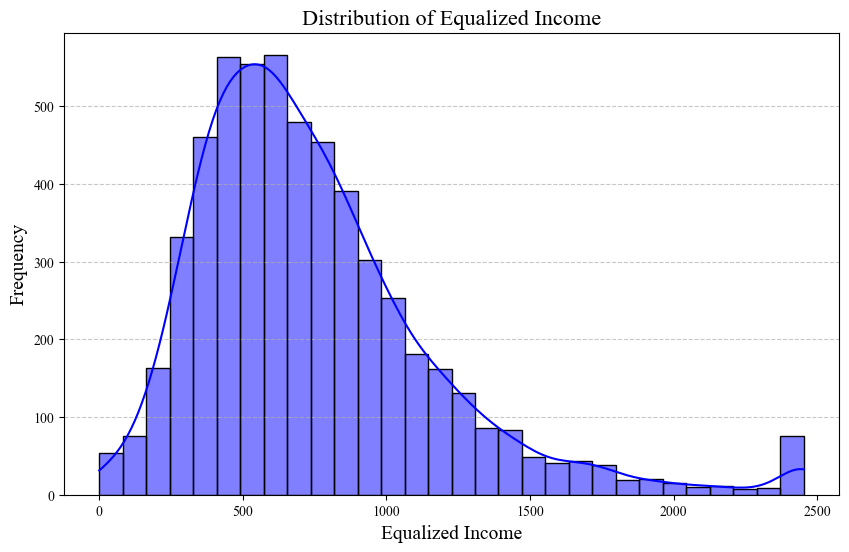

In [12]:
print(filtered_data2022['Equivalised_income_McClements'].describe())

# 2. Histogram of the Distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data2022['Equivalised_income_McClements'], bins=30, kde=True, color='blue')
plt.title('Distribution of Equalized Income', fontsize=16)
plt.xlabel('Equalized Income', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

------

**Part 3: Fixed-effects model**

-----

In [13]:
# Simple linear regression

# Define the independent (X) and dependent (y) variables
X = filtered_data2022['Equivalised_income_McClements']  # Income
y = filtered_data2022['experienced_inflation']  # Experienced Inflation

# Add a constant term to the independent variable (required for statsmodels regression)
X = sm.add_constant(X)

# Perform the linear regression
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     experienced_inflation   R-squared:                       0.072
Model:                               OLS   Adj. R-squared:                  0.071
Method:                    Least Squares   F-statistic:                     433.3
Date:                   Fri, 24 Jan 2025   Prob (F-statistic):           9.05e-93
Time:                           14:33:09   Log-Likelihood:                -10116.
No. Observations:                   5628   AIC:                         2.024e+04
Df Residuals:                       5626   BIC:                         2.025e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [14]:
# Fixed-effects model with controls

# Define dependent and independent variables
X = filtered_data2022[["Equivalised_income_McClements", "Retired_vs_other", 'Rural_or_urban', 'Own_vs_rent_binary', 'Location', 'Household_size']]  # Add controls
y = filtered_data2022['experienced_inflation']

# One-hot encode all categorical variables
X = pd.get_dummies(X, columns=["Retired_vs_other", 'Rural_or_urban', 'Own_vs_rent_binary', 'Location', 'Household_size'], drop_first=True)

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X.astype(float)).fit()

# Print the results
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     experienced_inflation   R-squared:                       0.165
Model:                               OLS   Adj. R-squared:                  0.163
Method:                    Least Squares   F-statistic:                     58.47
Date:                   Fri, 24 Jan 2025   Prob (F-statistic):          3.28e-203
Time:                           14:33:09   Log-Likelihood:                -9816.5
No. Observations:                   5628   AIC:                         1.967e+04
Df Residuals:                       5608   BIC:                         1.981e+04
Df Model:                             19                                         
Covariance Type:               nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

The results indicate that a 1-unit increase in equivalised income, the model predicts that experienced inflation decreases by 0.0006 units. This means that for an increase of £1000 change in income per month, experienced inflation decreases by 0.8%. 

---

**Part 4: Multilevel model**

---

In [17]:
# Define the formula for the multilevel model
# Random intercept and random slope for income by Location
formula = """
experienced_inflation ~ Equivalised_income_McClements + Own_vs_rent_binary + 
Retired_vs_other + Rural_or_urban + C(Household_size)
"""

# Fit the random intercept and random slope model
model = smf.mixedlm(
    formula=formula,
    data=filtered_data2022,
    groups=filtered_data2022["Location"],  # Grouping variable
    re_formula="~Equivalised_income_McClements"  # Random slope for income
)

# Fit the model and get results
result = model.fit()

# Print the summary
print(result.summary())

                        Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       experienced_inflation
No. Observations:       5628          Method:                   REML                 
No. Groups:             12            Scale:                    1.9148               
Min. group size:        205           Log-Likelihood:           -9967.9520           
Max. group size:        815           Converged:                Yes                  
Mean group size:        469.0                                                        
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                  9.457    0.390  24.268 0.000  8.693 10.221
C(Household_size)[T.2]                    -0.178    0.046  -3.847 0.000 -0.269

/Users/gianjaeger/Desktop/Applied Analytical Statistics/stats/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gianjaeger/Desktop/Applied Analytical Statistics/stats/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/gianjaeger/Desktop/Applied Analytical Statistics/stats/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [18]:
print(result.random_effects)

{np.int64(1): Group                           -0.087375
Equivalised_income_McClements    0.000082
dtype: float64, np.int64(2): Group                           -0.008297
Equivalised_income_McClements   -0.000067
dtype: float64, np.int64(3): Group                           -0.012254
Equivalised_income_McClements   -0.000073
dtype: float64, np.int64(4): Group                            0.010337
Equivalised_income_McClements   -0.000062
dtype: float64, np.int64(5): Group                           -0.187325
Equivalised_income_McClements    0.000045
dtype: float64, np.int64(6): Group                           -0.073430
Equivalised_income_McClements    0.000179
dtype: float64, np.int64(7): Group                            0.296619
Equivalised_income_McClements    0.000219
dtype: float64, np.int64(8): Group                           -0.220058
Equivalised_income_McClements    0.000241
dtype: float64, np.int64(9): Group                           -0.011870
Equivalised_income_McClements    0.00012

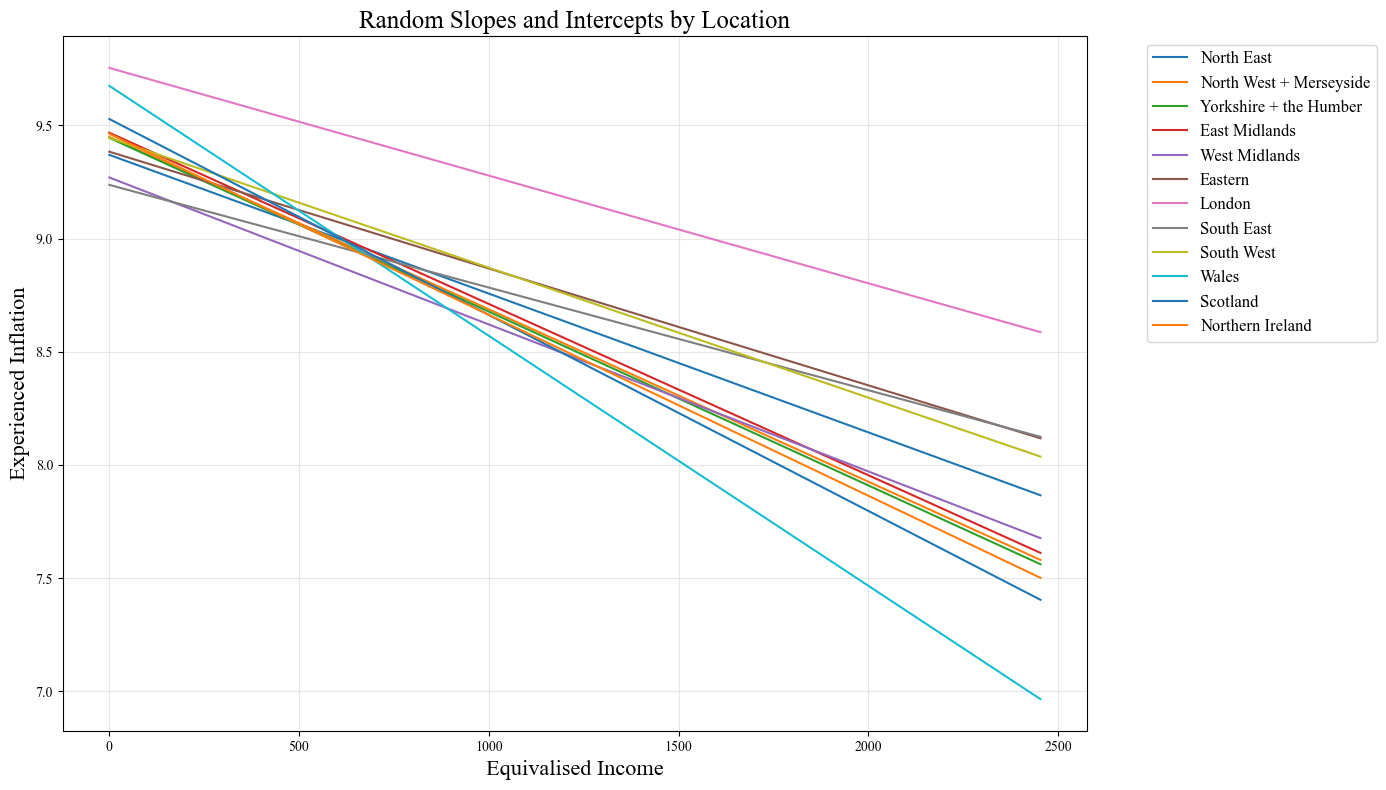

In [19]:
# Extract fixed effects
fixed_intercept = result.fe_params["Intercept"]
fixed_slope = result.fe_params["Equivalised_income_McClements"]

# Extract random effects (group-specific intercepts and slopes)
random_effects = result.random_effects

# Map location numbers to names (based on your order in the screenshot)
location_names = [
    "North East",
    "North West + Merseyside",
    "Yorkshire + the Humber",
    "East Midlands",
    "West Midlands",
    "Eastern",
    "London",
    "South East",
    "South West",
    "Wales",
    "Scotland",
    "Northern Ireland"
]

# Prepare the plot
plt.figure(figsize=(14, 8))  # Adjusted size for a wide plot

# Overlay group-specific regression lines
for location, effects in random_effects.items():
    # Calculate group-specific intercept and slope
    group_intercept = fixed_intercept + effects["Group"]  # Group-specific intercept
    group_slope = fixed_slope + effects.get("Equivalised_income_McClements", 0)  # Group-specific slope

    # Generate x values for the lines
    x_vals = np.linspace(
        filtered_data2022["Equivalised_income_McClements"].min(),
        filtered_data2022["Equivalised_income_McClements"].max(),
        100
    )
    # Generate y values using the group-specific intercept and slope
    y_vals = group_intercept + group_slope * x_vals

    # Use the location name from the mapping
    location_name = location_names[int(location) - 1]  # Adjust index for 0-based Python indexing
    plt.plot(x_vals, y_vals, label=f"{location_name}")

# Add labels, legend, and title
plt.xlabel("Equivalised Income", fontsize=16)  # Larger font for axis title
plt.ylabel("Experienced Inflation", fontsize=16)  # Larger font for axis title
plt.title("Random Slopes and Intercepts by Location", fontsize=18)  # Larger title font

# Legend placed outside the plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)  # Legend outside to the right
plt.grid(alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

---

**Part 5: Testing the underlying assumptions**

---

**Assumption 1: Linearity**

In [20]:
# Define the dependent variable (y) and independent variables (X)
X = filtered_data2022[['Equivalised_income_McClements']]
y = filtered_data2022['experienced_inflation']  # Dependent variable

# Add a constant term to the independent variables (for the intercept)
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X).fit()

# Store predictions
y_pred = model.predict(X)

In [21]:
# Run the lack-of-fit test (Rainbow test)
rainbow_stat, rainbow_p_value = linear_rainbow(model)
print(f"Rainbow Test Statistic: {rainbow_stat}")
print(f"Rainbow Test p-value: {rainbow_p_value}")

# Interpretation
if rainbow_p_value > 0.01:
    print("Linearity assumption is met.")
else:
    print("Linearity assumption is violated.")

Rainbow Test Statistic: 1.0857292089035313
Rainbow Test p-value: 0.014602477926000288
Linearity assumption is met.


**Assumption 3: Multicolinearity**

In [22]:
# Drop rows with NaN in 'Job_control' and 'Location'
filtered_data2022 = filtered_data2022.dropna(subset=['Job_control', 'Location'])

# Create dummy variables for 'Job_control'
job_dummies = pd.get_dummies(filtered_data2022['Job_control'], prefix='Job_control', drop_first=True)
filtered_data2022 = pd.concat([filtered_data2022, job_dummies], axis=1)

# Create dummy variables for 'Location'
location_dummies = pd.get_dummies(filtered_data2022['Location'], prefix='Location', drop_first=True)
filtered_data2022 = pd.concat([filtered_data2022, location_dummies], axis=1)

# Define independent variables, including all dummy variables for Location and Job_control
X = filtered_data2022[
    ['Equivalised_income_McClements', 'Rural_or_urban', 'Own_vs_rent_binary', 'Household_size'] + 
    [col for col in filtered_data2022.columns if col.startswith('Location_') or col.startswith('Job_control_')]
]

# Add a constant for the intercept
X = sm.add_constant(X)

# Convert all boolean columns to int64
X = X.astype({col: 'int64' for col in X.select_dtypes(include='bool').columns})
X['Rural_or_urban'] = pd.to_numeric(X['Rural_or_urban'], errors='coerce')

X = X.dropna()  # Drop rows with NaN values

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print(vif_data)

                         Variable        VIF
0                           const  62.759618
1   Equivalised_income_McClements   1.333667
2                  Rural_or_urban   1.100348
3              Own_vs_rent_binary   1.103969
4                  Household_size   1.188084
5                 Job_control_2.0   4.148410
6                 Job_control_3.0   2.249112
7                 Job_control_4.0   1.195301
8                 Job_control_5.0   4.325844
9                      Location_2   3.202917
10                     Location_3   2.989798
11                     Location_4   2.678413
12                     Location_5   2.942576
13                     Location_6   3.191230
14                     Location_7   3.135894
15                     Location_8   3.783319
16                     Location_9   3.471658
17                    Location_10   2.040778
18                    Location_11   4.271192
19                    Location_12   2.470412


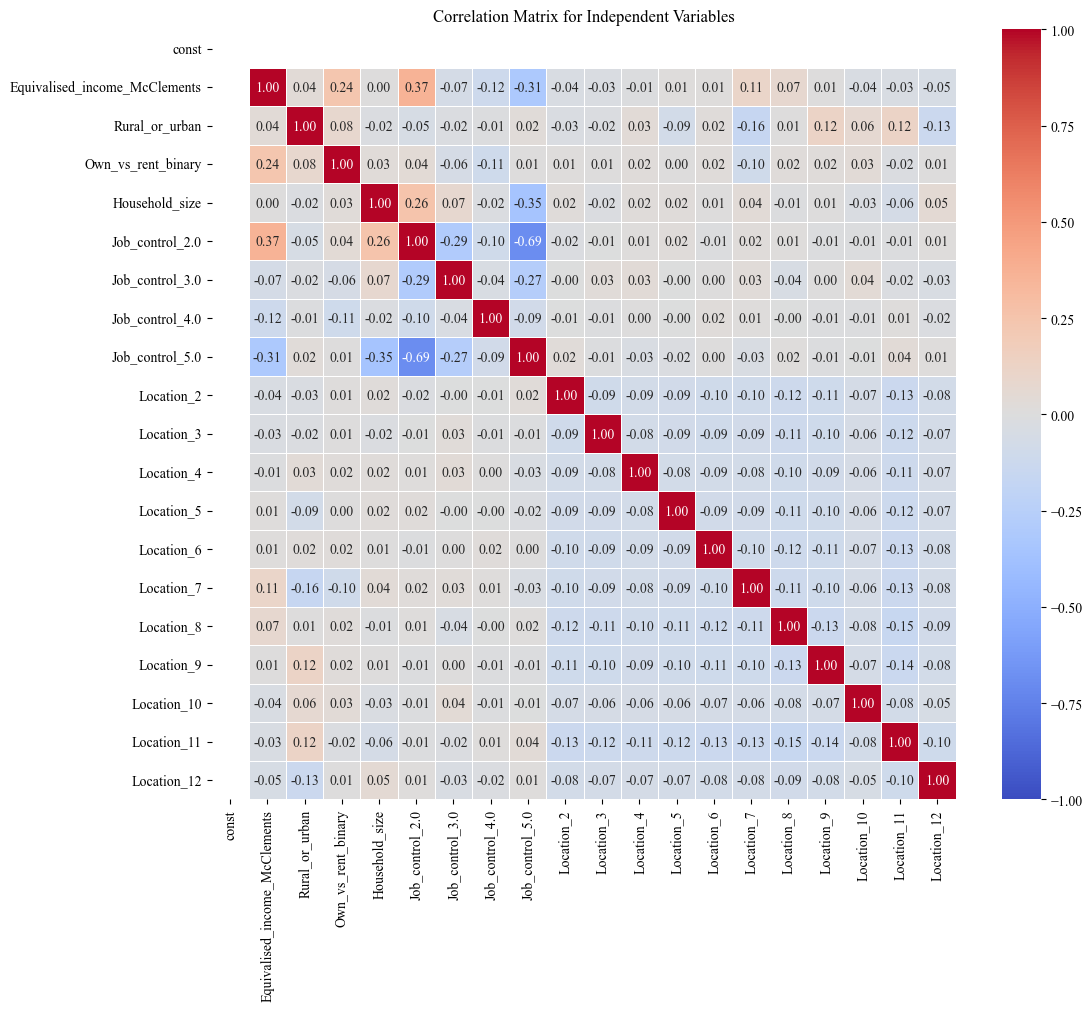

In [23]:
# Calculate the correlation matrix for independent variables
correlation_matrix = X.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix for Independent Variables")
plt.show()

**Assumption 3: Homoscedastictiy**

In [24]:
# Rereun regression 
X = filtered_data2022[['Equivalised_income_McClements']]
y = filtered_data2022['experienced_inflation']  # Dependent variable

# Add a constant term to the independent variables (for the intercept)
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X).fit()

# Perform Breusch-Pagan test (CHECKS FOR HOMOSCELASTICITY)
bp_test = het_breuschpagan(model.resid, X)
print(f"Lagrange Multiplier Stat: {bp_test[0]}")
print(f"p-value: {bp_test[1]}")

if bp_test[1] > 0.05:
    print("No evidence of heteroscedasticity.")
else:
    print("Heteroscedasticity detected.")

Lagrange Multiplier Stat: 1.1494189244904556
p-value: 0.2836708220972732
No evidence of heteroscedasticity.


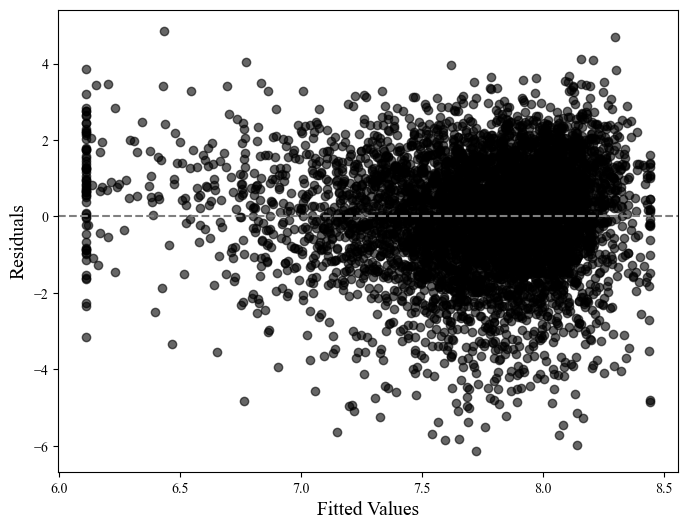

In [25]:
# Assuming y and X are already defined and prepared for regression (if this returns an error rerun the regression above)
# Fit the regression model
model = sm.OLS(y, X).fit()

# Get residuals and fitted values
residuals = model.resid
fitted_values = model.fittedvalues

# Plot residuals vs. fitted values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, color='black', alpha=0.6)  # Black dots
plt.axhline(y=0, color='gray', linestyle='--')  # Gray dashed line
plt.xlabel('Fitted Values', color='black', fontsize=14)
plt.ylabel('Residuals', color='black', fontsize=14)
plt.xticks(color='black')
plt.yticks(color='black')
plt.show()

**Assuption 4: Independent errors**

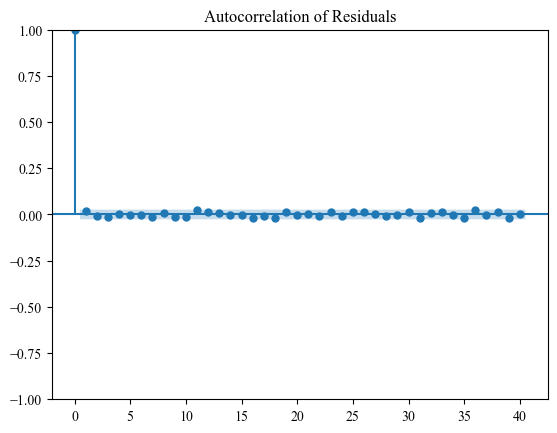

In [26]:
# Plot autocorrelation function (ACF) for residuals
plot_acf(model.resid, lags=40)
plt.title("Autocorrelation of Residuals")
plt.show()

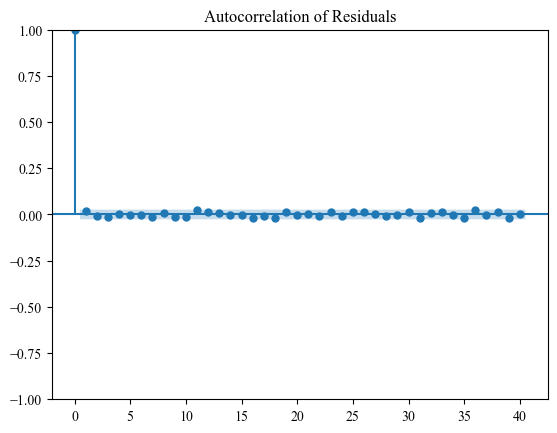

Durbin-Watson Statistic: 1.9579026444823417
Residuals are likely independent (no significant autocorrelation).


In [27]:
# Plot autocorrelation function (ACF) for residuals
plot_acf(model.resid, lags=40)
plt.title("Autocorrelation of Residuals")
plt.show()

# Fit the model
model = sm.OLS(y, X).fit()

# Calculate Durbin-Watson statistic
dw_statistic = durbin_watson(model.resid)

print(f"Durbin-Watson Statistic: {dw_statistic}")

# Interpretation
if 1.5 <= dw_statistic <= 2.5:
    print("Residuals are likely independent (no significant autocorrelation).")
else:
    print("Residuals may exhibit autocorrelation.")

**Assumption 5: Normally distributed residuals**

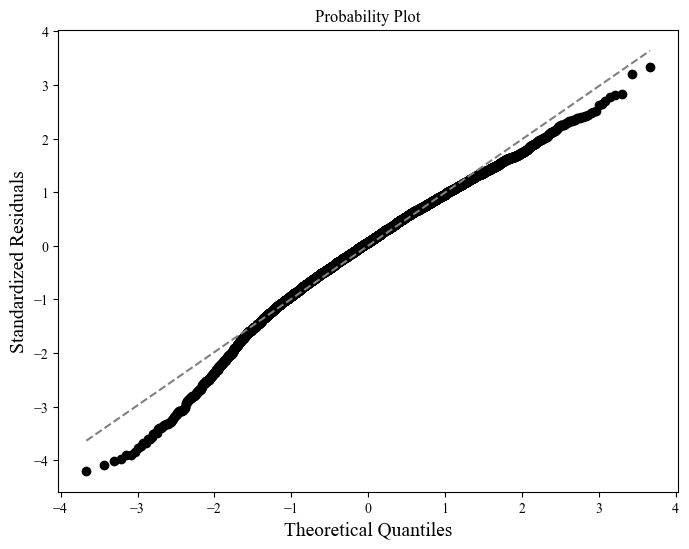

/Users/gianjaeger/Desktop/Applied Analytical Statistics/stats/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.9839004769342798), pvalue=np.float64(8.227064195180118e-25))

In [28]:
# Fit a linear regression model

X = add_constant(filtered_data2022["Equivalised_income_McClements"])  # Add a constant term for the intercept
y = filtered_data2022["experienced_inflation"]
model = OLS(y, X).fit()

# Calculate standardized residuals
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Assuming standardized_residuals are already calculated
# Q-Q Plot for standardized residuals
plt.figure(figsize=(8, 6))
qq_plot = stats.probplot(standardized_residuals, dist="norm", plot=plt)

# Customizing the plot to make it black and white
plt.gca().get_lines()[0].set_color('black')  # Points in black
plt.gca().get_lines()[1].set_color('gray')   # Reference line in gray
plt.gca().get_lines()[1].set_linestyle('--') # Dashed line for reference line
plt.xlabel("Theoretical Quantiles", color="black", fontsize=14)  # Bigger x-axis label
plt.ylabel("Standardized Residuals", color="black", fontsize=14)  # Bigger y-axis label
plt.xticks(color="black")
plt.yticks(color="black")
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)
shapiro_test

-----